## ResNet101 + CBAM

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet101, preprocess_input
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

2025-07-02 01:13:00.492267: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751418780.735144      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751418780.806967      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
base_dir = '/kaggle/input/eyepacs-aptos-messidor-diabetic-retinopathy/augmented_resized_V2'  # Update path if needed
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

IMG_SIZE = 224  # ResNet101 standard input
BATCH_SIZE = 32
NUM_CLASSES = 5


In [3]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = datagen.flow_from_directory(train_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical')
val_gen   = datagen.flow_from_directory(val_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
test_gen  = datagen.flow_from_directory(test_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)


Found 115241 images belonging to 5 classes.
Found 14227 images belonging to 5 classes.
Found 14201 images belonging to 5 classes.


In [4]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Add, Multiply, Conv2D, Lambda, Concatenate, Activation

def cbam_block(input_feature, ratio=8):
    channel = input_feature.shape[-1]

    # ----- Channel Attention -----
    shared_dense_one = Dense(channel // ratio, activation='relu')
    shared_dense_two = Dense(channel)

    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_out = shared_dense_two(shared_dense_one(avg_pool))

    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_out = shared_dense_two(shared_dense_one(max_pool))

    channel_attention = Add()([avg_out, max_out])
    channel_attention = Activation('sigmoid')(channel_attention)
    channel_refined = Multiply()([input_feature, channel_attention])

    # ----- Spatial Attention -----
    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(channel_refined)
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(channel_refined)
    concat = Concatenate(axis=3)([avg_pool, max_pool])

    spatial_attention = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)
    refined_feature = Multiply()([channel_refined, spatial_attention])

    return refined_feature

In [5]:
from tensorflow.keras.applications import ResNet101
from tensorflow.keras import layers, models, optimizers

IMG_SIZE = 224
NUM_CLASSES = 5



# Load base ResNet101
base_model = ResNet101(include_top=False, weights=None, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = True  # Full fine-tuning

# Build model
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=True)
x = cbam_block(x)  # 🔍 Add CBAM here
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

resnet_cbam_model = models.Model(inputs, outputs)
resnet_cbam_model.compile(optimizer=optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
resnet_cbam_model.summary()

I0000 00:00:1751253169.297655      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751253169.298478      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet101 (Functional)    │ (None, 7, 7, 2048)     │     42,658,176 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 2048)           │              0 │ resnet101[0][0]        │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling2d      │ (None, 2048)           │              0 │ resnet101[0][0]        │
│ (GlobalMaxPooling2D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 2048)     │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 1, 1, 2048)     │              0 │ global_max_pooling2d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1, 1, 256)      │        524,544 │ reshape[0][0],         │
│                           │                        │                │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1, 1, 2048)     │        526,336 │ dense[0][0],           │
│                           │                        │                │ dense[1][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 1, 1, 2048)     │              0 │ dense_1[0][0],         │
│                           │                        │                │ dense_1[1][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 1, 1, 2048)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 7, 7, 2048)     │              0 │ resnet101[0][0],       │
│                           │                        │                │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 7, 7, 1)        │              0 │ multiply[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 7, 7, 1)        │              0 │ multiply[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 7, 7, 2)        │              0 │ lambda[0][0],          │
│                           │                        │                │ lambda_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 7, 7, 1)        │             99 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_1 (Multiply)

 Total params: 44,244,200 (168.78 MB)

 Trainable params: 44,134,248 (168.36 MB)

 Non-trainable params: 109,952 (429.50 KB)

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint_cb = ModelCheckpoint('/kaggle/working/best_resnet101_cbam.h5', save_best_only=True, monitor='val_loss')
earlystop_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

history = resnet_cbam_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr_cb]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1751253269.545841      84 service.cc:148] XLA service 0x7b1f34005230 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751253269.546846      84 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751253269.546871      84 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751253278.863440      84 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751253311.246864      84 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3602/3602 ━━━━━━━━━━━━━━━━━━━━ 2186s 568ms/step - accuracy: 0.4076 - loss: 1.6358 - val_accuracy: 0.5277 - val_loss: 6.1817 - learning_rate: 1.0000e-04
Epoch 2/50
3602/3602 ━━━━━━━━━━━━━━━━━━━━ 1963s 545ms/step - accuracy: 0.5498 - loss: 1.2439 - val_accuracy: 0.5822 - val_loss: 1.5315 - learning_rate: 1.0000e-04
Epoch 3/50
3602/3602 ━━━━━━━━━━━━━━━━━━━━ 1959s 544ms/step - accuracy: 0.5710 - loss: 1.1855 - val_accuracy: 0.5990 - val_loss: 1.1144 - learning_rate: 1.0000e-04
Epoch 4/50
3602/3602 ━━━━━━━━━━━━━━━━━━━━ 1958s 544ms/step - accuracy: 0.5915 - loss: 1.1321 - val_accuracy: 0.6109 - val_loss: 1.0742 - learning_rate: 1.0000e-04
Epoch 5/50
3602/3602 ━━━━━━━━━━━━━━━━━━━━ 1959s 544ms/step - accuracy: 0.6064 - loss: 1.0747 - val_accuracy: 0.6352 - val_loss: 0.9844 - learning_rate: 1.0000e-04
Epoch 6/50
3602/3602 ━━━━━━━━━━━━━━━━━━━━ 1968s 546ms/step - accuracy: 0.6289 - loss: 1.0047 - val_accuracy: 0.6642 - val_loss: 0.9382 - learning_rate: 1.0000e-04
Epoch 7/50
3602/3602 ━━━━━━━━━━━━

In [7]:
import pickle

# Save history to disk
with open("ResNet_Cbam_training_history.pkl", "wb") as f:
    pickle.dump(history.history, f)

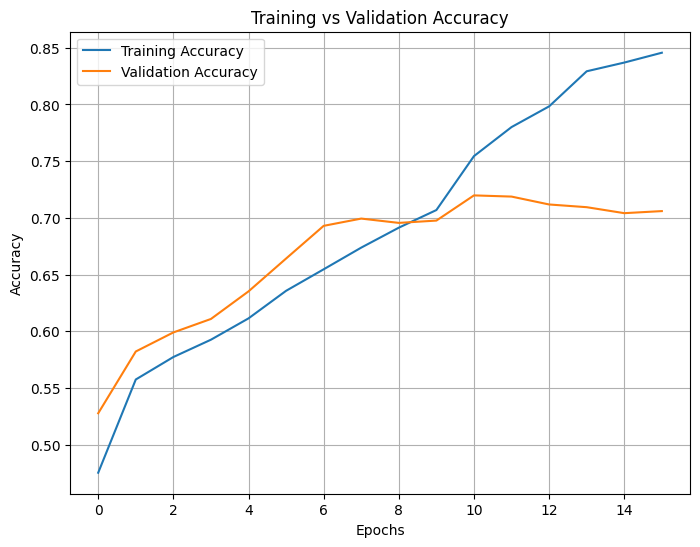

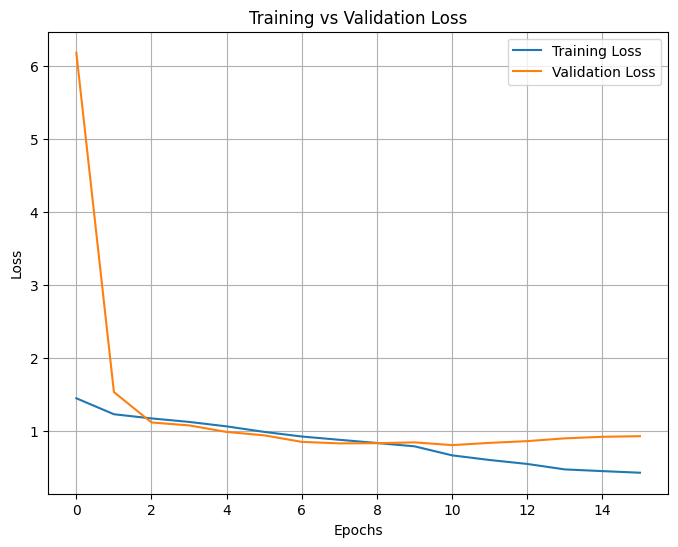

In [8]:
history_data = history.history

import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(history_data['accuracy'], label='Training Accuracy')
plt.plot(history_data['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.figure(figsize=(8, 6))
plt.plot(history_data['loss'], label='Training Loss')
plt.plot(history_data['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

444/444 ━━━━━━━━━━━━━━━━━━━━ 173s 371ms/step
              precision    recall  f1-score   support

           0     0.7779    0.9668    0.8621      6896
           1     0.3519    0.4216    0.3836      1862
           2     0.3977    0.1711    0.2392      2999
           3     0.3362    0.1984    0.2495       978
           4     0.5150    0.5382    0.5264      1466

    accuracy                         0.6301     14201
   macro avg     0.4757    0.4592    0.4522     14201
weighted avg     0.5842    0.6301    0.5910     14201



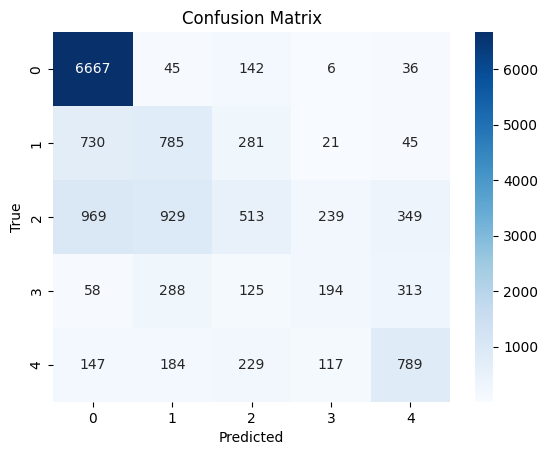

Quadratic Weighted Kappa (QWK): 0.6946


In [9]:
y_true = test_gen.classes
y_pred_probs = resnet_cbam_model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

qwk = cohen_kappa_score(y_true, y_pred, weights='quadratic')
print(f"Quadratic Weighted Kappa (QWK): {qwk:.4f}")